# TEXT EMOTION PREDICTION

In [1]:
!pip install text_hammer

In [2]:
import pandas as pd
import numpy as np
import text_hammer as th
import re

import matplotlib.pyplot as plt
import seaborn as sns


### Loading the dataset

In [3]:
train_ds = pd.read_csv('emotions-dataset-for-nlp/train.txt', header=None, sep=';', names=['text', 'sentiment'], encoding='ISO-8859-1')
val_ds = pd.read_csv('emotions-dataset-for-nlp/val.txt', header=None, sep=';', names=['text', 'sentiment'], encoding='ISO-8859-1')
test_ds = pd.read_csv('emotions-dataset-for-nlp/test.txt', header=None, sep=';', names=['text', 'sentiment'], encoding='ISO-8859-1')

In [4]:
train_ds.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


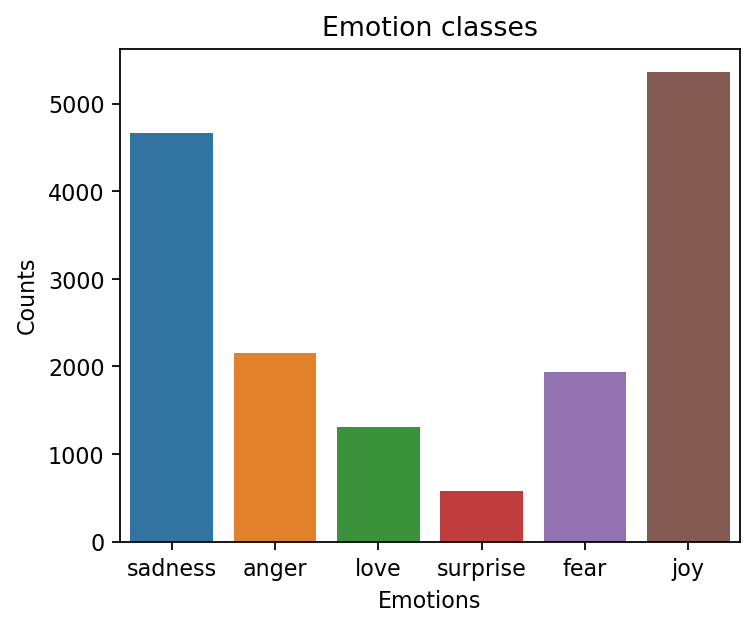

In [5]:
# Confirm the balance

fig = plt.figure(figsize=(5,4), dpi=160)
sns.countplot(x='sentiment', data=train_ds)
plt.title('Emotion classes')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.show()

In [6]:
# Calculatin weight in order to manage imbalanced data for prediction >>> not used as there is almost no impact to the result.

#class_samples = train_ds["sentiment"].value_counts().to_dict()
#max_samples = max(class_samples.values())  

#class_weights = {cls: max_samples / count for cls, count in class_samples.items()}
#print(class_weights)

In [7]:
## Concatinate the vector data
data_full = pd.concat([train_ds, val_ds, test_ds], axis=0)

In [8]:
# Confirm the nulls, types.
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


### Data pre-processing

In [9]:
%%time

def text_preprocessing(dataset, colname):
    try:
        dataset[colname] = dataset[colname].progress_apply(lambda x: str(x).lower())
        dataset[colname] = dataset[colname].progress_apply(lambda x: th.cont_exp(x))
        dataset[colname] = dataset[colname].progress_apply(lambda x: th.remove_emails(x))
        dataset[colname] = dataset[colname].progress_apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', " ", x))
        dataset[colname] = dataset[colname].progress_apply(lambda x: th.remove_html_tags(x))
        dataset[colname] = dataset[colname].progress_apply(lambda x: th.remove_special_chars(x))
        dataset[colname] = dataset[colname].progress_apply(lambda x: th.remove_accented_chars(x))
        
        return dataset
    except ValueError as ve:
        print(f"Exception during text preprocessing {ve}")

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
data_full = text_preprocessing(data_full, 'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [11]:
## Encoding the sentiment values into numeric codes
data_full['sentiment'] = data_full.sentiment.astype('category')
data_full['sentiment_code'] = data_full.sentiment.cat.codes

In [12]:
## Label encoding
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [13]:
data_full.head()

,text,sentiment,sentiment_code
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


### Splitting data into input variables and target variable

In [14]:
from sklearn.model_selection import train_test_split

In [19]:
X_train_full, X_val, y_train_full, y_val = train_test_split(data_full['text'].tolist(), 
                                                 data_full['sentiment_code'].tolist(),
                                                 test_size=0.2,
                                                 stratify=data_full['sentiment_code'].tolist(),
                                                 random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2,
                                                   stratify=y_train_full, random_state=42)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

import joblib
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

**Logistic Regression**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initializing and training Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_vectorized, y_train)

# Predicting on test set
predictions = lr_model.predict(X_test_vectorized)
predictions_tr = lr_model.predict(X_train_vectorized)
print(predictions)
print(type(predictions))

# Evaluating model performance
accuracy = accuracy_score(y_test, predictions)
accuracy_tr = accuracy_score(y_train, predictions_tr)
print("Accuracy:", accuracy, accuracy_tr)

[4 2 4 ... 4 2 1]
<class 'numpy.ndarray'>
Accuracy: 0.8425 0.931640625


c:\Users\mkcor\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**SVM**

In [22]:
from sklearn.svm import SVC

# Initializing and training Logistic Regression model
svc_model = SVC(kernel = 'rbf', C = 1, class_weight='balanced')
svc_model.fit(X_train_vectorized, y_train)

# Predicting on test set
predictions = svc_model.predict(X_test_vectorized)
predictions_tr = svc_model.predict(X_train_vectorized)

# Evaluating model performance
accuracy = accuracy_score(y_test, predictions)
accuracy_tr = accuracy_score(y_train, predictions_tr)
print("Accuracy:", accuracy, accuracy_tr) 

Accuracy: 0.8440625 0.985703125


**Random Forest**

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initializing and training Logistic Regression model
rf_model = RandomForestClassifier(n_estimators=10,max_depth=None)
rf_model.fit(X_train_vectorized, y_train)

# Predicting on test set
predictions = rf_model.predict(X_test_vectorized)
predictions_tr = rf_model.predict(X_train_vectorized)

# Evaluating model performance
accuracy = accuracy_score(y_test, predictions)
accuracy_tr = accuracy_score(y_train, predictions_tr)
print("Accuracy:", accuracy, accuracy_tr)

Accuracy: 0.7915625 0.993984375


### Saving the model - Apply the RogisticRegression Model (Least Overfitting)

In [24]:
import joblib
pipeline_file = open("text_model_lr.pkl","wb")
joblib.dump(lr_model,pipeline_file)
pipeline_file.close()